In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob

# **image Preprocess**

In [51]:
images_path = '../input/flickr8k-sau/Flickr_Data/Images/'
images = glob(images_path+'*.jpg')
len(images)


8091

In [52]:
images[:5]

['../input/flickr8k-sau/Flickr_Data/Images/3226254560_2f8ac147ea.jpg',
 '../input/flickr8k-sau/Flickr_Data/Images/214543992_ce6c0d9f9b.jpg',
 '../input/flickr8k-sau/Flickr_Data/Images/2366643786_9c9a830db8.jpg',
 '../input/flickr8k-sau/Flickr_Data/Images/3368819708_0bfa0808f8.jpg',
 '../input/flickr8k-sau/Flickr_Data/Images/2190227737_6e0bde2623.jpg']

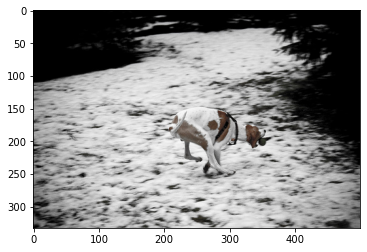

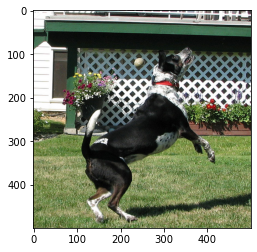

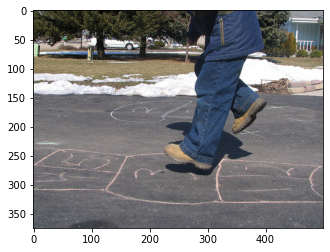

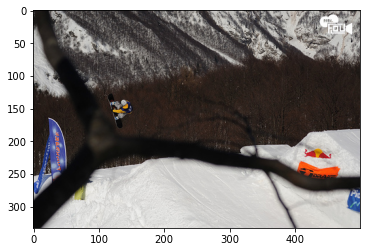

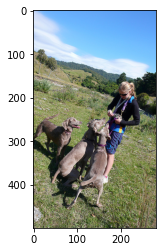

In [53]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [55]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

incept_model = ResNet50(include_top=True)


In [56]:
from keras.models import Model
last = incept_model.layers[-2].output
modele = Model(inputs = incept_model.input,outputs = last)
modele.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [57]:
images_features = {}
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    img = img.reshape(1,224,224,3)
    pred = modele.predict(img).reshape(2048,)
        
    img_name = i.split('/')[-1]
    
    images_features[img_name] = pred
    
    count += 1
    
    if count > 50:
        break
        
    elif count % 50 == 0:
        print(count)
    
        
    

50


In [58]:
len(images_features)

51

# **Text Preprocess**

In [59]:
caption_path = '../input/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'

In [60]:
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')

In [61]:
len(captions)

40461

In [62]:
captions_dict = {}
for i in captions:
    try:
        img_name = i.split('\t')[0][:-2] 
        caption = i.split('\t')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]
                
            else:
                captions_dict[img_name].append(caption)
            
    except:
        pass

In [63]:
len(captions_dict)

51

# **Visualize Images with captions**

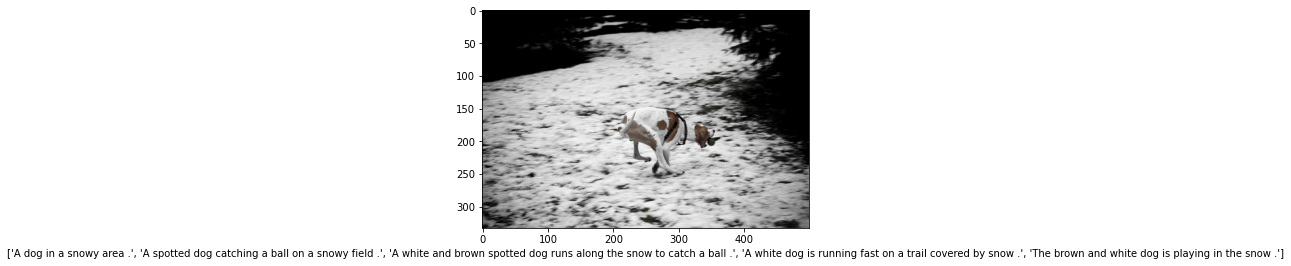

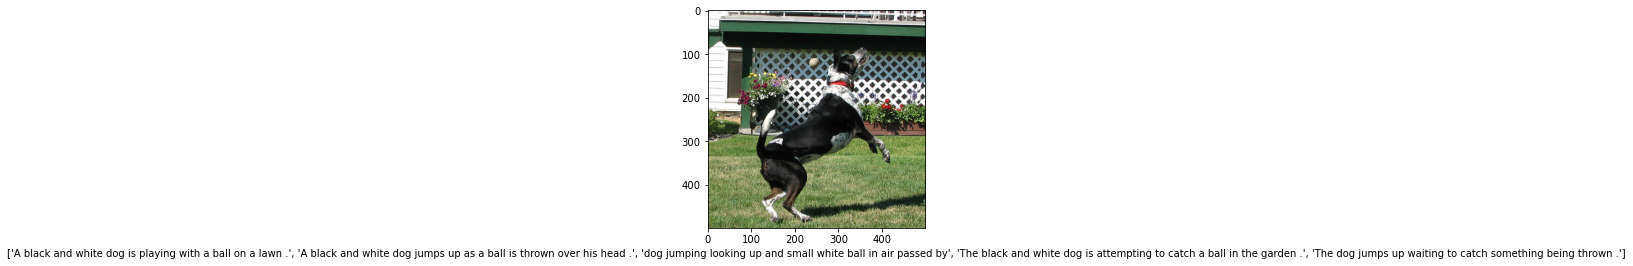

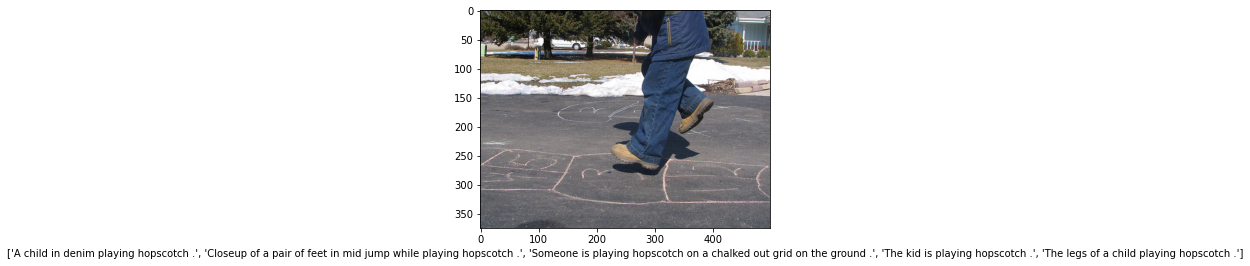

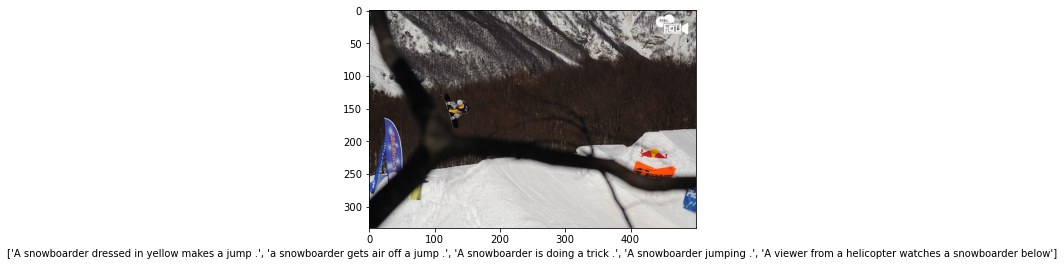

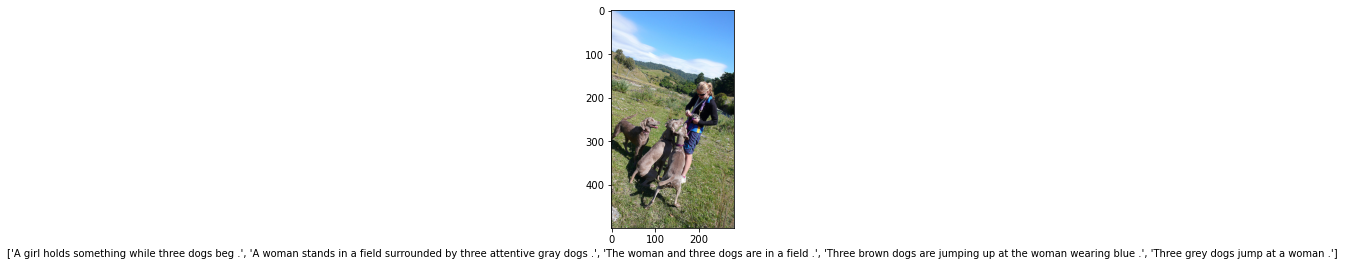

In [64]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img_name = images[i]
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)

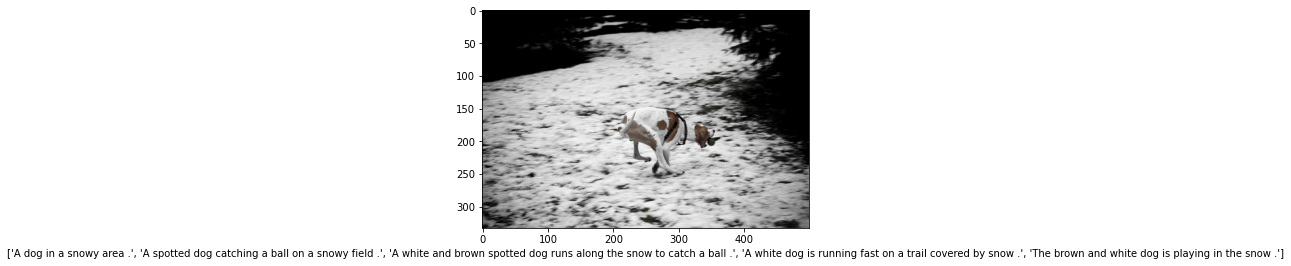

In [65]:
import matplotlib.pyplot as plt

for k in images_features.keys():
    plt.figure()
    
    img_name = '../input/flickr8k-sau/Flickr_Data/Images/' + k
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)
    
    break

In [66]:

def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq'
    return modified
    

In [67]:
for k,v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv)

# **Create Vocabulary**

In [68]:
count_words = {}
for k,vv in captions_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:

                count_words[word] = 0

            else:
                count_words[word] += 1

In [69]:
len(count_words)

564

In [70]:
THRESH = -1
count = 1
new_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        new_dict[k] = count
        count += 1
        

In [71]:
len(new_dict)

564

In [73]:
new_dict['<OUT>'] = len(new_dict) 


In [74]:
captions_backup = captions_dict.copy()

In [75]:
captions_dict = captions_backup.copy()

In [76]:
for k, vv in captions_dict.items():
    for v in vv:
        encoded = []
        for word in v.split():  
            if word not in new_dict:
                encoded.append(new_dict['<OUT>'])
            else:
                encoded.append(new_dict[word])


        captions_dict[k][vv.index(v)] = encoded

In [77]:
#captions_dict

------------------------------------------------------------------------------------------------------

# **Build Generator Function**

In [28]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [78]:
MAX_LEN = 0
for k, vv in captions_dict.items():
    for v in vv:
        if len(v) > MAX_LEN:
            MAX_LEN = len(v)
            print(v)

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 10, 5, 11, 12, 13, 2, 14, 15, 16, 7, 8, 9]
[1, 12, 2, 17, 18, 19, 4, 20, 21, 22, 23, 5, 8, 9]
[1, 20, 30, 36, 45, 42, 43, 44, 25, 39, 46, 20, 47, 48, 49, 8, 9]
[1, 20, 70, 4, 71, 72, 20, 73, 74, 36, 55, 4, 29, 75, 23, 20, 69, 4, 76, 8, 9]
[1, 12, 124, 125, 17, 126, 127, 128, 129, 130, 11, 131, 132, 125, 17, 133, 126, 29, 132, 134, 8, 9]
[1, 20, 70, 25, 20, 318, 142, 4, 319, 320, 72, 20, 51, 73, 74, 55, 10, 29, 311, 23, 20, 186, 25, 321, 320, 72, 20, 96, 153, 10, 20, 312, 8, 9]


In [79]:
MAX_LEN

34

In [30]:
#captions_dict

In [80]:
Batch_size = 5000
VOCAB_SIZE = len(new_dict)

def generator(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)
            
    return X, y_in, y_out
    
    

In [81]:
X, y_in, y_out = generator(images_features, captions_dict)

In [82]:
len(X), len(y_in), len(y_out)

(3272, 3272, 3272)

In [83]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')



In [84]:
X.shape, y_in.shape, y_out.shape

((3272, 2048), (3272, 34), (3272, 565))

In [85]:
X[1510]

array([0.4996253 , 0.7709093 , 0.09171978, ..., 1.2074729 , 0.26972982,
       0.43004197], dtype=float32)

In [86]:
y_in[2]

array([1., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# **MODEL**

In [87]:

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model

In [88]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(new_dict)

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               262272    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 34, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 34, 128)           72320     
_________________________________________________________________
lstm_3 (LSTM)                (None, 34, 256)           394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 34, 128)           32896     
Total params: 499,456
Trai

In [89]:
model.fit([X, y_in], y_out, batch_size=512, epochs=200)

Epoch 1/200
7/7 [==============================] - 0s 43ms/step - loss: 5.4181 - accuracy: 0.0721
Epoch 2/200
7/7 [==============================] - 0s 42ms/step - loss: 4.8879 - accuracy: 0.1042
Epoch 3/200
7/7 [==============================] - 0s 42ms/step - loss: 4.8680 - accuracy: 0.0944
Epoch 4/200
7/7 [==============================] - 0s 41ms/step - loss: 4.8516 - accuracy: 0.0957
Epoch 5/200
7/7 [==============================] - 0s 41ms/step - loss: 4.8306 - accuracy: 0.0966
Epoch 6/200
7/7 [==============================] - 0s 41ms/step - loss: 4.7861 - accuracy: 0.0993
Epoch 7/200
7/7 [==============================] - 0s 41ms/step - loss: 4.7302 - accuracy: 0.0984
Epoch 8/200
7/7 [==============================] - 0s 41ms/step - loss: 4.7294 - accuracy: 0.0960
Epoch 9/200
7/7 [==============================] - 0s 41ms/step - loss: 4.6470 - accuracy: 0.0889
Epoch 10/200
7/7 [==============================] - 0s 42ms/step - loss: 4.6476 - accuracy: 0.1039
Epoch 11/200
7/7 [=

In [90]:
inv_dict = {v:k for k, v in new_dict.items()}

In [91]:
model.save('model.h5')

In [92]:
model.save_weights('mine_model_weights.h5')

In [93]:
np.save('vocab.npy', new_dict)

In [94]:
# function to get the image 
def getImage(x):
    
    test_img_path = images[x]

    test_img = cv2.imread(test_img_path) # read from path
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (224,224))

    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img

# **Predictions**

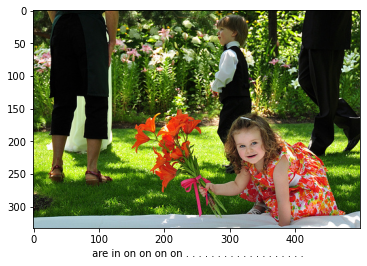

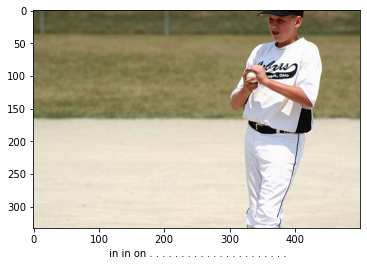

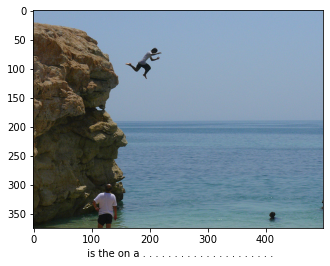

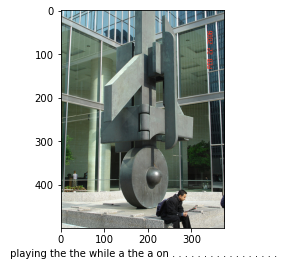

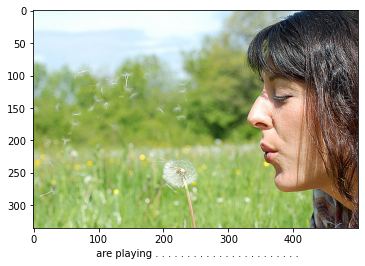

In [95]:
for i in range(5):
    
    no = np.random.randint(1500,7000,(1,1))[0,0]
    test_feature = modele.predict(getImage(no)).reshape(1,2048)
    
    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(count_words[i])

        encoded = [encoded]

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


        prediction = np.argmax(model.predict([test_feature, encoded]))

        sampled_word = inv_dict[prediction]

        caption = caption + ' ' + sampled_word
            
        if sampled_word == 'endofseq':
            break

        text_inp.append(sampled_word)
        
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)

In [49]:
count_words

{'startofseq': 2504,
 'a': 3888,
 'little': 120,
 'girl': 223,
 'covered': 15,
 'in': 1241,
 'paint': 3,
 'sits': 36,
 'front': 89,
 'of': 377,
 'painted': 7,
 'rainbow': 3,
 'with': 488,
 'her': 56,
 'hands': 15,
 'bowl': 2,
 '.': 2284,
 'endofseq': 2504,
 'is': 594,
 'sitting': 98,
 'large': 69,
 'small': 64,
 'the': 1115,
 'grass': 111,
 'plays': 49,
 'fingerpaints': 0,
 'white': 240,
 'canvas': 0,
 'on': 674,
 'it': 26,
 'there': 17,
 'pigtails': 2,
 'painting': 2,
 'young': 184,
 'outside': 47,
 'man': 435,
 'drilling': 2,
 'hole': 1,
 'ice': 13,
 'through': 107,
 'frozen': 5,
 'pond': 6,
 'person': 84,
 'snow': 95,
 'standing': 108,
 'lake': 30,
 'two': 383,
 'men': 64,
 'are': 222,
 'fishing': 4,
 'boy': 235,
 'cleans': 0,
 'bubbles': 1,
 'off': 29,
 'his': 126,
 'face': 24,
 'suds': 0,
 'has': 22,
 'wiped': 0,
 'clean': 0,
 'child': 106,
 'foam': 2,
 'climbing': 35,
 'black': 215,
 'inflatable': 8,
 'ramp': 12,
 'soapy': 0,
 'water': 164,
 'getting': 3,
 'cleaned': 0,
 'woman':